# Time Series Forecasting

Using the acres burned dataframe, we will construct a forecast that will predict acres burned over the next 10 years. This will then be used to create predictions for wildfire suppression costs and insurance losses.

In [1]:
# Check conda environment - should be sktime
!conda env list

# conda environments:
#
base                     /Users/claireph/opt/anaconda3
sktime                *  /Users/claireph/opt/anaconda3/envs/sktime



In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.model_selection import temporal_train_test_split

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [3]:
acres_df = pd.read_csv('./claire_data/acres_clean.csv', index_col='Unnamed: 0')

In [4]:
acres_df.tail()

,acres_burned
2016,5.402921e+05
2017,1.415352e+06
2018,1.584802e+06
2019,2.753229e+05
2020,4.149345e+06


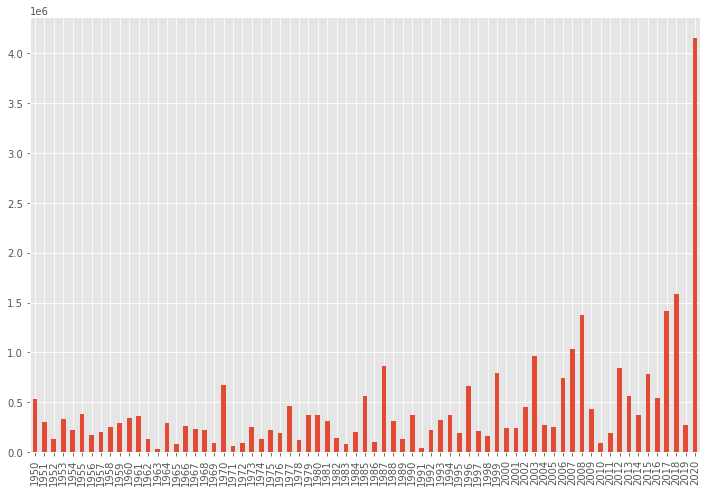

In [5]:
acres_df['acres_burned'].plot(kind='bar', figsize=(12,8));

In [6]:
y = acres_df['acres_burned'].reset_index(drop=True)
y

0     5.375387e+05
1     3.057212e+05
2     1.323705e+05
3     3.338548e+05
4     2.187340e+05
          ...     
66    5.402921e+05
67    1.415352e+06
68    1.584802e+06
69    2.753229e+05
70    4.149345e+06
Name: acres_burned, Length: 71, dtype: float64

In [7]:
y_train, y_test = temporal_train_test_split(y, test_size=12)

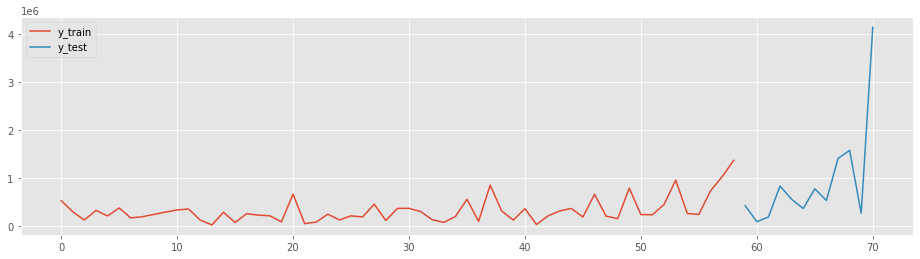

In [8]:
plot_ys(y_train, y_test, labels=['y_train', 'y_test']);

In [9]:
naive_model_mean = NaiveForecaster(strategy='mean')
naive_model_mean.fit(y_train)
y_preds_mean = naive_model_mean.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_mean)

677354.3152964265

In [10]:
naive_model_season = NaiveForecaster(strategy='last', sp=10)
naive_model_season.fit(y_train)
y_preds_season = naive_model_season.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_season)

600149.5509583333

In [11]:
sarima_model = AutoARIMA(sp=10, suppress_warnings=True)
sarima_model.fit(y_train)
y_preds_sarima = sarima_model.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_sarima)

655003.6104576733

In [12]:
hw_model = AutoETS(auto=True, sp=10)
hw_model.fit(y_train.astype('float'))
y_preds_hw = hw_model.predict(list(range(1, len(y_test)+1)))
mean_absolute_error(y_test, y_preds_hw)

628600.4056897515

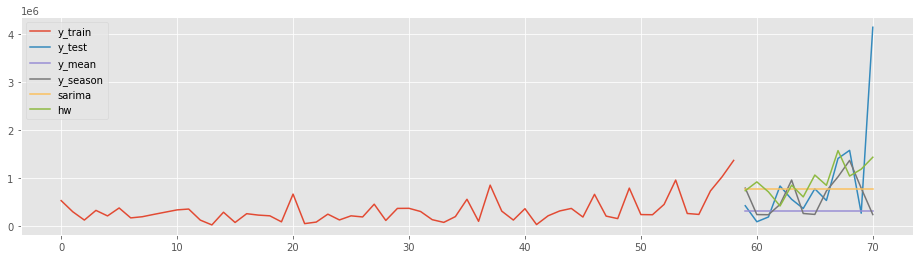

In [13]:
plot_ys(y_train, y_test, y_preds_mean, y_preds_season, y_preds_sarima, y_preds_hw,
        labels=['y_train', 'y_test', 'y_mean', 'y_season', 'sarima', 'hw']);

In [15]:
naive_model_season_ext = NaiveForecaster(strategy='last', sp=10)
naive_model_season_ext.fit(y)
y_preds_season_ext = naive_model_season_ext.predict(list(range(1, 11)))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

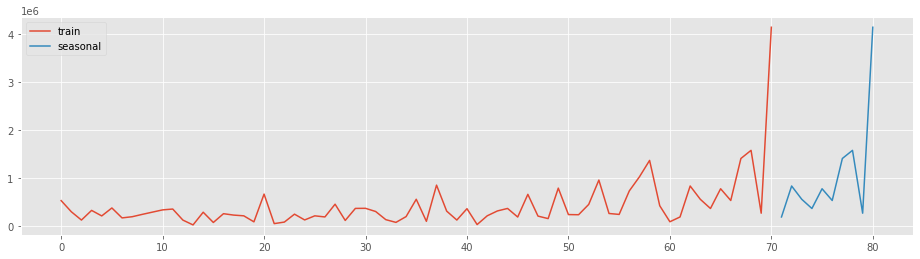

In [16]:
plot_ys(y, y_preds_season_ext, labels = ['train', 'seasonal'])

In [34]:
predictions_df = pd.DataFrame(
    {'year': list(range(2021, 2031)),
     'pred_acres': y_preds_season_ext})

In [36]:
predictions_df['pred_cost'] = predictions_df['pred_acres'] * 3072.86

In [43]:
predictions_df['pred_structures_destroyed'] = predictions_df['pred_acres'] * 0.0047

In [44]:
# Source: https://pbpython.com/styling-pandas.html
format_dict = {'pred_acres': '{0:,.0f}', 'pred_cost':'${0:,.0f}', 'pred_structures_destroyed': '{0:,.2f}'}
predictions_df.style.format(format_dict).hide_index()

year,pred_acres,pred_cost,pred_structures_destroyed
2021,"196,854","$604,903,386",925.21
2022,"841,911","$2,587,075,378","3,956.98"
2023,"564,818","$1,735,605,859","2,654.64"
2024,"373,381","$1,147,348,793","1,754.89"
2025,"784,716","$2,411,323,662","3,688.17"
2026,"540,292","$1,660,242,038","2,539.37"
2027,"1,415,352","$4,349,177,416","6,652.15"
2028,"1,584,802","$4,869,876,147","7,448.57"
2029,"275,323","$846,028,819","1,294.02"
2030,"4,149,345","$12,750,356,277","19,501.92"
